In [1]:
## Echo Python Version to be sure it is from virtual environment
import sys
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Definitions
1. **Nominal interest** rates are set by government. 
Also, for different period (such as 5, 10, 15, etc.. **Zinsbindungszeit**) of fixed interest (**Zinsbindungsfrist**) have different rates.
Please look at sources to get present value of fixed interest rate for each period.
3. Annual bank **nominal interest rate** is compounded over 12 months. Therefore, **periodic interest rate** = nominal_interest_rate / 12
4. **Principal** amount does not include notary fees, real estate agent fees, grundwerbsteuer
5. We as customers can decide on **principal repayment rate**. Cannot be lesser than 1.5%
6. Fixed monthly payment can be derived by adding the periodic_interest_rate + periodic_prepayment_rate
7. Based on fixed monthly payments, we can then calculate how many years we need to pay the loan (**Annuitätendarlehen Laufzeit**)

Sources:
- https://data.ecb.europa.eu/data/datasets/MIR/MIR.M.U2.B.A2C.A.R.A.2250.EUR.N
- https://hypofriend.de/en/german-mortgage-calculator

### Example Amortized Fixed Monthly Payment Calculator
**number of compounding period** is fixed in the following case. <br/>
However, in reality this is calculated based on fixed monthly payment rate. <br/>
Following is an example using the amortized loan formula to calculate the fixed monthly payment

In [3]:
# Using the amortized loan formula, calculating the fixed monthly payments
PRINCIPAL_AMOUNT = 400000
BANK_INTEREST_RATE = 3.82 / 100
PREPAYMENT_RATE = 2.0
MONTHS_IN_YEAR = 12
ANNUAL_COMPOUNDING_PERIOD = MONTHS_IN_YEAR
PERIODIC_INTEREST_RATE = BANK_INTEREST_RATE/ANNUAL_COMPOUNDING_PERIOD
print("Periodic Interest Rate: ", PERIODIC_INTEREST_RATE)
TOTAL_COMPOUNDING_PERIODS = 28 * ANNUAL_COMPOUNDING_PERIOD
print("Total compounding period over 28 years: ", TOTAL_COMPOUNDING_PERIODS)
INTEREST_RATE_POW = math.pow((1 + PERIODIC_INTEREST_RATE), TOTAL_COMPOUNDING_PERIODS)

Fixed_Monthly_Payments = (PERIODIC_INTEREST_RATE * PRINCIPAL_AMOUNT * INTEREST_RATE_POW) / (INTEREST_RATE_POW - 1)
print("Fixed monthly payments: ", Fixed_Monthly_Payments)

Periodic Interest Rate:  0.003183333333333333
Total compounding period over 28 years:  336
Fixed monthly payments:  1940.2559463940336


## Calculator of Loan Period (Annuitätendarlehen Laufzeit)
It can be calculated if following are known with this [formula](https://math.stackexchange.com/questions/3185889/how-do-i-solve-for-n-number-of-periods-in-a-loan-repayment-formula)
* **principal**
* **nominal interest rate**
* **principal repayment rate**

In [4]:
# YOU CAN VARY ONLY THE FOLLOWING VALUES
PRINCIPAL_AMOUNT = 220000
BANK_INTEREST_RATE = 3.82 / 100
PREPAYMENT_RATE = 2.0 / 100
MONTHS_IN_YEAR = 12

# Calculate Fixed Monthly Payments
ANNUAL_COMPOUNDING_PERIOD = MONTHS_IN_YEAR
PERIODIC_INTEREST_RATE = BANK_INTEREST_RATE / ANNUAL_COMPOUNDING_PERIOD
print("Periodic Interest Rate: ", PERIODIC_INTEREST_RATE)
PERIODIC_PRINCIPAL_REPAY_RATE = PREPAYMENT_RATE / ANNUAL_COMPOUNDING_PERIOD
print("Periodic Principal Repayment Rate: ", PERIODIC_PRINCIPAL_REPAY_RATE)
FIXED_MONTHLY_PAYMENT = (PERIODIC_INTEREST_RATE + PERIODIC_PRINCIPAL_REPAY_RATE) * PRINCIPAL_AMOUNT
print("Fixed monthly payment: ", FIXED_MONTHLY_PAYMENT)

# Calculate Total Loan Period
LOAN_PERIOD = math.log(FIXED_MONTHLY_PAYMENT / (FIXED_MONTHLY_PAYMENT - (PERIODIC_INTEREST_RATE * PRINCIPAL_AMOUNT)), 1 + PERIODIC_INTEREST_RATE)
LOAN_PERIOD_IN_YEARS = LOAN_PERIOD / MONTHS_IN_YEAR
print("Number of years to payback the loan: ", LOAN_PERIOD_IN_YEARS)

Periodic Interest Rate:  0.003183333333333333
Periodic Principal Repayment Rate:  0.0016666666666666668
Fixed monthly payment:  1067.0
Number of years to payback the loan:  28.006605346853163


## Calculate Total Interest Paid at the end of loan period

In [5]:
starting_data = {
    "princip_remain": [PRINCIPAL_AMOUNT],
    "princip_repaid_amt": [0],
    "interest_paid_amt": [0],
    "monthly_payment": [0]
}
periodic_loan_calc = pd.DataFrame(starting_data)
for prev_period_num in range(int(LOAN_PERIOD)):
    principal_prev_period = periodic_loan_calc.at[prev_period_num, "princip_remain"]
    interest_paid = PERIODIC_INTEREST_RATE * principal_prev_period
    principal_repaid = FIXED_MONTHLY_PAYMENT - interest_paid
    remaining_principal_amt = principal_prev_period - principal_repaid
    period_data = {
        "princip_remain": remaining_principal_amt,
        "princip_repaid_amt": principal_repaid,
        "interest_paid_amt": interest_paid,
        "monthly_payment": principal_repaid + interest_paid
    }
    period_df = pd.DataFrame([period_data])
    periodic_loan_calc = pd.concat([periodic_loan_calc, period_df], ignore_index=True)
    periodic_loan_calc = periodic_loan_calc.round(decimals=2)

print(periodic_loan_calc)

total_interest_paid = periodic_loan_calc['interest_paid_amt'].sum()
print("Total Interest paid at the end of the loan period: ", total_interest_paid)

     princip_remain  princip_repaid_amt  interest_paid_amt  monthly_payment
0         220000.00                0.00               0.00              0.0
1         219633.33              366.67             700.33           1067.0
2         219265.50              367.83             699.17           1067.0
3         218896.50              369.00             698.00           1067.0
4         218526.32              370.18             696.82           1067.0
..              ...                 ...                ...              ...
332         4317.63             1049.91              17.09           1067.0
333         3264.37             1053.26              13.74           1067.0
334         2207.76             1056.61              10.39           1067.0
335         1147.79             1059.97               7.03           1067.0
336           84.44             1063.35               3.65           1067.0

[337 rows x 4 columns]
Total Interest paid at the end of the loan period:  138596.44


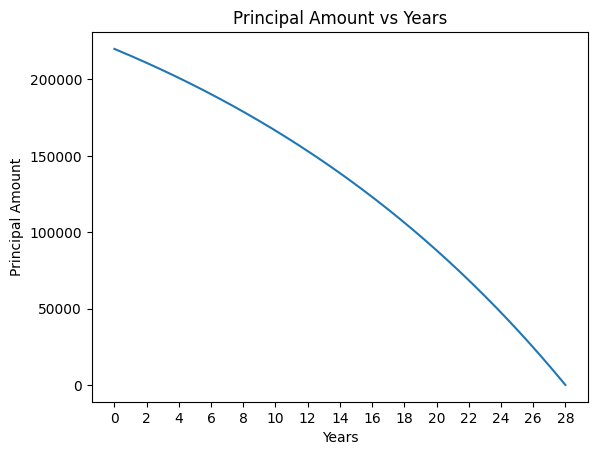

In [6]:
x = periodic_loan_calc.index
y = periodic_loan_calc['princip_remain']
plt.plot(x, y)
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
# While labelling ticks show them as years
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])
plt.xlabel("Years")
plt.ylabel("Principal Amount")
plt.title('Principal Amount vs Years')
plt.show()

## Marking the Interest paid until 5, 10, 15 years

In [7]:
cumm_interest_df = pd.DataFrame({"cumm_interest_paid": periodic_loan_calc['interest_paid_amt'].cumsum()})
interest_table = pd.concat([periodic_loan_calc['interest_paid_amt'], cumm_interest_df], axis=1)
print(interest_table)

# Calculate total interest paid every 5 year
every_five_year_cumm_interest = interest_table.loc[::12*5, ['cumm_interest_paid']].copy() # copy() as loc return reference to original df
tmp = every_five_year_cumm_interest.index.to_numpy() / 12
every_five_year_cumm_interest["year"] = tmp.astype(int)
every_five_year_cumm_interest.index.name = "month"

     interest_paid_amt  cumm_interest_paid
0                 0.00                0.00
1               700.33              700.33
2               699.17             1399.50
3               698.00             2097.50
4               696.82             2794.32
..                 ...                 ...
332              17.09           138561.63
333              13.74           138575.37
334              10.39           138585.76
335               7.03           138592.79
336               3.65           138596.44

[337 rows x 2 columns]


       cumm_interest_paid  year
month                          
0                    0.00     0
60               39820.92     5
120              74557.73    10
180             103142.38    15
240             124282.37    20
300             136413.61    25


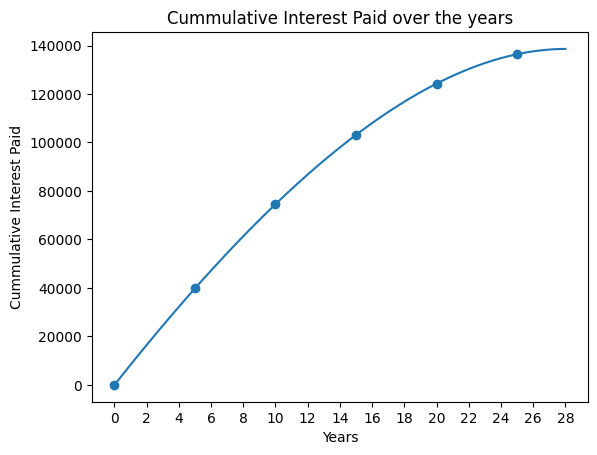

In [8]:
# Put markers of cummulative interest paid every 5 years
x = every_five_year_cumm_interest.index
y = every_five_year_cumm_interest['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)
print(every_five_year_cumm_interest)

# Plot line for the cummulative interest
x = interest_table.index
y = interest_table['cumm_interest_paid']
plt.plot(x, y)
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
# While labelling ticks show them as years
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])
plt.xlabel("Years")
plt.ylabel("Cummulative Interest Paid")
plt.title('Cummulative Interest Paid over the years')
plt.show()

## Loan Calculation with 2%, 3%, 5% repayment at Annually

In [9]:

def loan_calc_with_annual_repayment(ann_repay_rate):
    starting_data = {
        "princip_remain": [PRINCIPAL_AMOUNT],
        "princip_repaid_amt": [0],
        "interest_paid_amt": [0],
        "monthly_payment": [0]
    }
    periodic_loan_calc = pd.DataFrame(starting_data)
    additional_ann_princip_repay = ann_repay_rate * PRINCIPAL_AMOUNT
    print("Starting Principal: ", PRINCIPAL_AMOUNT)
    print("Additional Prinicpal Repay at end of each year: ", additional_ann_princip_repay)
    period_num = 0
    while periodic_loan_calc["princip_remain"].iloc[-1] > 0:# and len(periodic_loan_calc.index) < 13:
        principal_prev_period = periodic_loan_calc.at[period_num, "princip_remain"]
        interest_paid = PERIODIC_INTEREST_RATE * principal_prev_period
        principal_repaid = FIXED_MONTHLY_PAYMENT - interest_paid
        remaining_principal_amt = principal_prev_period - principal_repaid
        if remaining_principal_amt < 0:
            break
        period_data = {
            "princip_remain": remaining_principal_amt,
            "princip_repaid_amt": principal_repaid,
            "interest_paid_amt": interest_paid,
            "monthly_payment": principal_repaid + interest_paid
        }
        period_df = pd.DataFrame([period_data])
        periodic_loan_calc = pd.concat([periodic_loan_calc, period_df], ignore_index=True)
        period_num += 1

        if periodic_loan_calc.index[-1] % 12 == 0:
            #print(periodic_loan_calc.index[-1])
            #print(periodic_loan_calc.at[period_num, "princip_remain"])
            # If end of the year then repay the principal amount additionally
            periodic_loan_calc.loc[periodic_loan_calc.index[-1], "princip_remain"] = periodic_loan_calc.at[periodic_loan_calc.index[-1], "princip_remain"] - additional_ann_princip_repay
            #print(periodic_loan_calc)
    
        periodic_loan_calc = periodic_loan_calc.round(decimals=2)
    return periodic_loan_calc

Starting Principal:  220000
Additional Prinicpal Repay at end of each year:  4400.0
Starting Principal:  220000
Additional Prinicpal Repay at end of each year:  6600.0
Starting Principal:  220000
Additional Prinicpal Repay at end of each year:  11000.0


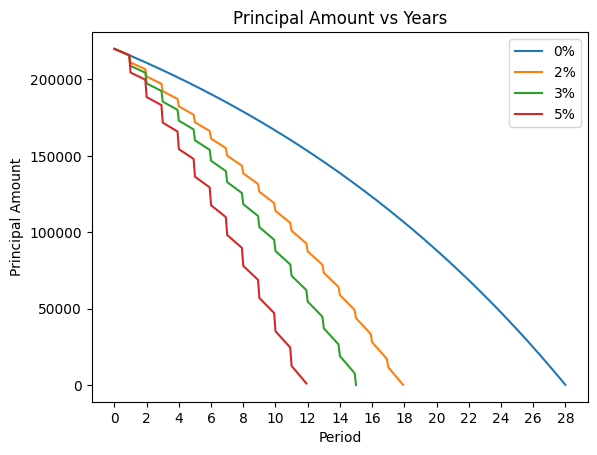

In [10]:
ANNUAL_REPAYMENT_RATE = 2 / 100
loan_calc_2 = loan_calc_with_annual_repayment(ANNUAL_REPAYMENT_RATE)

ANNUAL_REPAYMENT_RATE = 3 / 100
loan_calc_3 = loan_calc_with_annual_repayment(ANNUAL_REPAYMENT_RATE)

ANNUAL_REPAYMENT_RATE = 5 / 100
loan_calc_5 = loan_calc_with_annual_repayment(ANNUAL_REPAYMENT_RATE)

# Plot comparison of principal amount
x = periodic_loan_calc.index
y = periodic_loan_calc['princip_remain']
plt.plot(x, y, label="0%")
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])

x = loan_calc_2.index
y = loan_calc_2['princip_remain']
plt.plot(x, y, label="2%")

x = loan_calc_3.index
y = loan_calc_3['princip_remain']
plt.plot(x, y, label="3%")

x = loan_calc_5.index
y = loan_calc_5['princip_remain']
plt.plot(x, y, label="5%" )



# While labelling ticks show them as years
plt.xlabel("Period")
plt.ylabel("Principal Amount")
plt.title('Principal Amount vs Years')
plt.legend()
plt.show()

## Total Interest Calculation with 2%, 3%, 5% repayment at Annually

In [11]:
def show_cumm_interest_rate(loan_calc_df):
    cumm_interest_df = pd.DataFrame({"cumm_interest_paid": loan_calc_df['interest_paid_amt'].cumsum()})
    interest_table = pd.concat([loan_calc_df['interest_paid_amt'], cumm_interest_df], axis=1)
    return interest_table

total_interest_loan2 = show_cumm_interest_rate(loan_calc_2)
total_interest_loan3 = show_cumm_interest_rate(loan_calc_3)
total_interest_loan5 = show_cumm_interest_rate(loan_calc_5)
print("Total interest paid at the loan period with additional 2% annual repayment: ", total_interest_loan2['cumm_interest_paid'].iloc[-1])
print("Total interest paid at the loan period with additional 3% annual repayment: ", total_interest_loan3['cumm_interest_paid'].iloc[-1])
print("Total interest paid at the loan period with additional 5% annual repayment: ", total_interest_loan5['cumm_interest_paid'].iloc[-1])

Total interest paid at the loan period with additional 2% annual repayment:  84330.13000000005
Total interest paid at the loan period with additional 3% annual repayment:  71085.16000000003
Total interest paid at the loan period with additional 5% annual repayment:  54571.37999999999


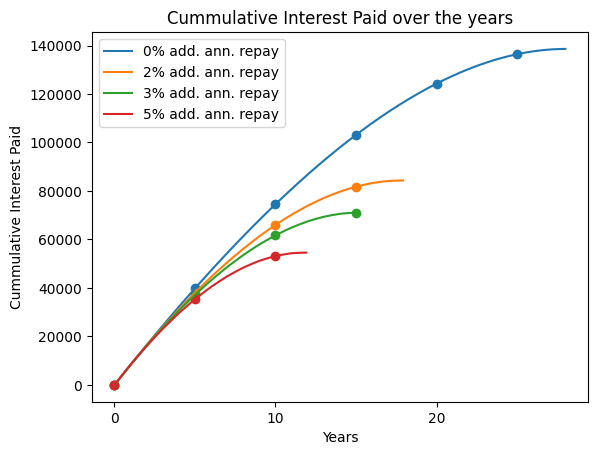

In [12]:
# Calculate total interest paid every 5 year
def calc_cumm_interest_every_5y(cumm_interest_df):
    every_five_year_cumm_interest = cumm_interest_df.loc[::12*5, ['cumm_interest_paid']].copy() # copy() as loc return reference to original df
    tmp = every_five_year_cumm_interest.index.to_numpy() / 12
    every_five_year_cumm_interest["year"] = tmp.astype(int)
    every_five_year_cumm_interest.index.name = "month"
    return every_five_year_cumm_interest

x = interest_table.index
y = interest_table['cumm_interest_paid']
plt.plot(x, y, label="0% add. ann. repay")
x = every_five_year_cumm_interest.index
y = every_five_year_cumm_interest['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)
# Show ticks only for following values
period_tick = [i for i in x.to_list() if i % 24 == 0]
# While labelling ticks show them as years
plt.xticks(period_tick, labels=[str(int(i / 12)) for i in period_tick])

# Plot line for the cummulative interest
x = total_interest_loan2.index
y = total_interest_loan2['cumm_interest_paid']
plt.plot(x, y, label="2% add. ann. repay")
# Put markers of cummulative interest paid every 5 years
every_five_year_cumm_interest_loan2 = calc_cumm_interest_every_5y(total_interest_loan2)
x = every_five_year_cumm_interest_loan2.index
y = every_five_year_cumm_interest_loan2['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)

# Plot line for the cummulative interest
x = total_interest_loan3.index
y = total_interest_loan3['cumm_interest_paid']
plt.plot(x, y, label="3% add. ann. repay")
# Put markers of cummulative interest paid every 5 years
every_five_year_cumm_interest_loan3 = calc_cumm_interest_every_5y(total_interest_loan3)
x = every_five_year_cumm_interest_loan3.index
y = every_five_year_cumm_interest_loan3['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)


x = total_interest_loan5.index
y = total_interest_loan5['cumm_interest_paid']
plt.plot(x, y, label="5% add. ann. repay")
# Put markers of cummulative interest paid every 5 years
every_five_year_cumm_interest_loan5 = calc_cumm_interest_every_5y(total_interest_loan5)
x = every_five_year_cumm_interest_loan5.index
y = every_five_year_cumm_interest_loan5['cumm_interest_paid'].to_numpy()
plt.scatter(x, y)

plt.xlabel("Years")
plt.ylabel("Cummulative Interest Paid")
plt.title('Cummulative Interest Paid over the years')
plt.legend()
plt.show()# Calculate total interest paid every 5 year


# Property Prices
## Berlin 
### Buying
Please follow this [page](https://hypofriend.de/en/property-prices-in-berlin.afb) to find the median prices per m2 in different regions of Berlin. 
1. The prices have increased by 10% each year until span of 6 years (from 2017 - 2023). 
2. Vacancy rate is the lowest of 0.91% and therefore, prices are still expected to rise. 
3. Berlin currently lacks more than 106.000 apartments. The calculation takes into account the difference between the number of inhabitants and the statistical household size minus the housing stock. 
### Renting
Please follow heading <em>Rental Market</em> in this [report](https://guthmann.estate/en/market-report/berlin/).
1. Renting an apartment can cost from around 700 € - 1500 € per month
2. Average asking rent can be from 10 - 16 € / m2 
3. Rent price was risen from 3 - 10 % from  Nov 2023 - Jan 2024

0.8706327524530828 [0.12730918] 6.534579591836735
0.9018765265588197 [0.0357342  0.00190781] 7.251916926770708


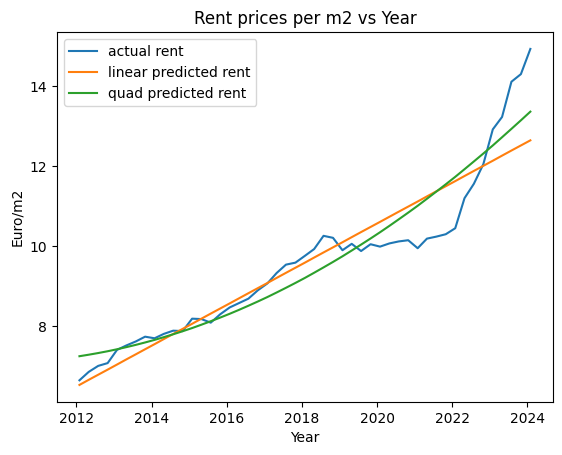

In [46]:
df = pd.read_csv("rent_vs_quarter_berlin.csv")
df['Date'] = pd.to_datetime(df['Date'])
#print(df.dtypes)
#print(df)

dates = df['Date']
rents = df['Rent_Price_m2']
plt.plot(dates, rents, label='actual rent')
plt.title('Rent prices per m2 vs Year')
plt.xlabel('Year')
plt.ylabel('Euro/m2')

from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
x = df.index.to_numpy().reshape((-1, 1))
y = rents.to_numpy()
linear_model.fit(x, y)
r_sq = linear_model.score(x, y)
slope = linear_model.coef_
intercept = linear_model.intercept_

print(r_sq, slope, intercept)
y_predicted = x * slope + intercept
y_predicted
plt.plot(dates, y_predicted, label='linear predicted rent')

from sklearn.preprocessing import PolynomialFeatures
quad_x = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
quad_x_df = pd.DataFrame(quad_x, columns=['x', 'x_2'])
quad_model = LinearRegression().fit(quad_x, y)
r_sq = quad_model.score(quad_x, y)
slope = quad_model.coef_
intercept = quad_model.intercept_

print(r_sq, slope, intercept)
y_predicted = quad_x_df['x_2'] * slope[1] + quad_x_df['x'] * slope[0] + intercept
plt.plot(dates, y_predicted, label="quad predicted rent")

plt.legend()
plt.show()# Calculate total interest paid every 5 year

## TODO 
# Appreciation graph
# Salary graph
# Renting graph with increase every year
# Break even point after buying

## Calculate Warmmieter/ Energy usage for apartment rented as WG